## Análise de Demandas da Fatec de Mauá (1/3) - P2 Machine Learning - Regressão Linear

Feito por:

- Adriano das Chagas Barros
- Brendon Gomes da Silva
- Elias Sousa Barbosa
- Rafael Ricardo Gonçalves

Foi feito a análise e interpretação de dados utilizando Regressão Linear e Pearson, com base em um caso de uso real para verificação do estado atual da demanda de inscritos dos cursos da Fatec de Mauá.

### Coleta dos dados

A coleta de dados foi realizada durante todo o período de divulgação da lista de inscritos Fatec de Mauá, desde 2007 a até 2025 (1º Semestre)

Para o processo de coleta de dados, foi uma Automação em C# .NET Framework com Selenium feito para automatizar o download de arquivos da demanda da FATEC de Mauá. Ele realiza o processo de web scrapping e navegação de extração das demandas de forma prática e rápida, exportando em um arquivo CSV.

Fonte dos dados: [Execução da automação - Fatec Demanda Downloader (.NET Framework)](https://github.com/Brendon3578/FatecDemandaDownloaderNetFramework)

## Normalização e Estrutura dos Dados

O processo de normalização padronizou os nomes dos cursos, períodos e colunas, permitindo comparações diretas e análises agregadas. Foram consideradas apenas as modalidades presenciais e noturnas, com os cursos principais: Polímeros, Logística, Informática para Negócios, Fabricação Mecânica e Desenvolvimento de Software Multiplataforma.

In [ ]:
import pandas as pd
import csv
import re

def detectar_separador(path):
    with open(path, 'r', encoding='utf-8') as f:
        sample = f.read(2048)  # Lê uma amostra do arquivo
        sniffer = csv.Sniffer()
        try:
            dialect = sniffer.sniff(sample, delimiters=[',', ';'])
            return dialect.delimiter
        except csv.Error:
            # Caso não detecte, usa vírgula como padrão
            return ','

def carregar_e_normalizar_fatec(path="fatec_demanda_data.csv"):
    sep = detectar_separador(path)
    df = pd.read_csv(path, sep=sep)
    df.columns = df.columns.str.strip().str.lower()
    if "curso" in df.columns:
        df["curso"] = df["curso"].str.strip().str.lower()
    if "periodo" in df.columns:
        df["periodo"] = df["periodo"].str.strip().str.lower()
        df["periodo"] = df["periodo"].replace({
            "noturno": "noite",
            "matutino": "manhã"
        })
    if "fatec" in df.columns:
        df["fatec"] = df["fatec"].str.strip().str.lower()
    def normalizar_curso(c):
        if "logística" in c:
            return "logística"
        if re.search(r"polímero|plástic", c):
            return "polímeros"
        if "informática" in c:
            return "informática para negócios"
        return c
    if "curso" in df.columns:
        df["curso"] = df["curso"].apply(normalizar_curso)
    for col in ["ano", "semestre", "inscritos", "vagas", "demanda"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

cursos = [
    "polímeros",
    "logística",
    "informática para negócios",
    "fabricação mecânica",
    "desenvolvimento de software multiplataforma"
]


# Exemplo de uso:
df_normalizado = carregar_e_normalizar_fatec()

df_normalizado


,fatec,ano,semestre,curso,periodo,inscritos,vagas,demanda
0,fatec mauá,2007,1,informática para negócios,noite,456,40,11.40
1,fatec mauá,2007,1,informática para negócios,tarde,168,40,4.20
2,fatec mauá,2007,1,polímeros,noite,352,40,8.80
3,fatec mauá,2007,2,informática para negócios,noite,363,40,9.08
4,fatec mauá,2007,2,informática para negócios,tarde,112,40,2.80
...,...,...,...,...,...,...,...,...
243,fatec mauá,2025,1,informática para negócios,manhã,42,24,1.75
244,fatec mauá,2025,1,informática para negócios,noite,105,34,3.09
245,fatec mauá,2025,1,logística,manhã,39,24,1.63
246,fatec mauá,2025,1,logística,noite,120,34,3.53


## Tendências Históricas e Regressão Linear

In [ ]:
# Função para interpretar a correlação de Pearson
def interpretar_pearson(r):
    abs_r = abs(r)
    if abs_r < 0.10:
        return "Desprezível"
    elif abs_r < 0.30:
        return "Fraca"
    elif abs_r < 0.50:
        return "Moderada"
    elif abs_r <= 1.00:
        return "Forte"
    return "Inválido"

# Função utilitária para fazer o filtro no DataFrame (os dados)
def filtrar_dados(df, semestre=None, periodo=None, excluir_curso=None, curso_especifico=None):
    if semestre is not None:
        df = df[df["semestre"] == semestre]
    if periodo is not None:
        df = df[df["periodo"] == periodo]
    if excluir_curso is not None:
        df = df[df["curso"] != excluir_curso]
    if curso_especifico is not None:
        df = df[df["curso"] == curso_especifico]

    df_filtrado = df[df["curso"].isin(cursos)]

    return df_filtrado



# Função que faz o filtro no DataFrame (os dados)
def demandas_fatec_maua(semestre=None, periodo=None, excluir_dsm=False, curso_especifico=None):
    df = carregar_e_normalizar_fatec()
    curso_excluido = "desenvolvimento de software multiplataforma" if excluir_dsm else None
    return filtrar_dados(df, semestre=semestre, periodo=periodo, excluir_curso=curso_excluido, curso_especifico=curso_especifico)

# Exemplo de uso:
df_1s_noturno = demandas_fatec_maua(semestre=1, periodo="noite")
df_1s_noturno_sem_dsm = demandas_fatec_maua(semestre=1, periodo="noite", excluir_dsm=True)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd


df_noturno = demandas_fatec_maua(semestre=1, periodo="noite")
# Coleta todos os anos únicos ordenados para usar no eixo X
anos_unicos = sorted(df_noturno["ano"].unique())

# Lista para armazenar os resultados
resultados = []
resultados_pearsonr = []

# Loop pelos cursos para a realização do cálculo de regressão linear e interpretação
for curso in cursos:
    f_curso = df_noturno[df_noturno["curso"] == curso]

    if f_curso.empty:
        print(f"Nenhum dado encontrado para o curso: {curso}")
        resultados.append((curso, None, None, None))
        continue

    # X = Ano, Y = Inscritos
    X = f_curso["ano"].values.reshape(-1, 1)
    y = f_curso["inscritos"].values

    # Criar modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X, y)

    # Previsão
    y_pred = modelo.predict(X)

    # Cálculo de métricas
    r2 = r2_score(y, y_pred)
    coef_angular = modelo.coef_[0]
    coef_linear = modelo.intercept_

    # Correlação de Pearson
    r_pearson, _ = pearsonr(X.flatten(), y)

    interpretacao = interpretar_pearson(r_pearson)

    # Armazena os resultados em tupla
    resultados.append((
        curso,
        round(r2, 4),
        round(coef_angular, 2),
        round(coef_linear, 2),
    ))
    resultados_pearsonr.append((
        curso,
        round(r_pearson, 4),
        interpretacao
    ))

## Interpretação dos resultados:

- De modo geral, todos os cursos mostraramm tendência de queda nas inscrições, com, correlação de Pearson moderada a forte.
- Polímeros apresenta queda acentuada nas inscrições, com correlação forte e coeficiente angular negativo.
- Fabricação Mecânica também apresenta tendência de queda, especialmente nos anos recentes.
- Desenvolvimento de Software Multiplataforma (DSM) apresenta dados recentes, mas com alta demanda, refletindo a tendência estadual de crescimento em tecnologia

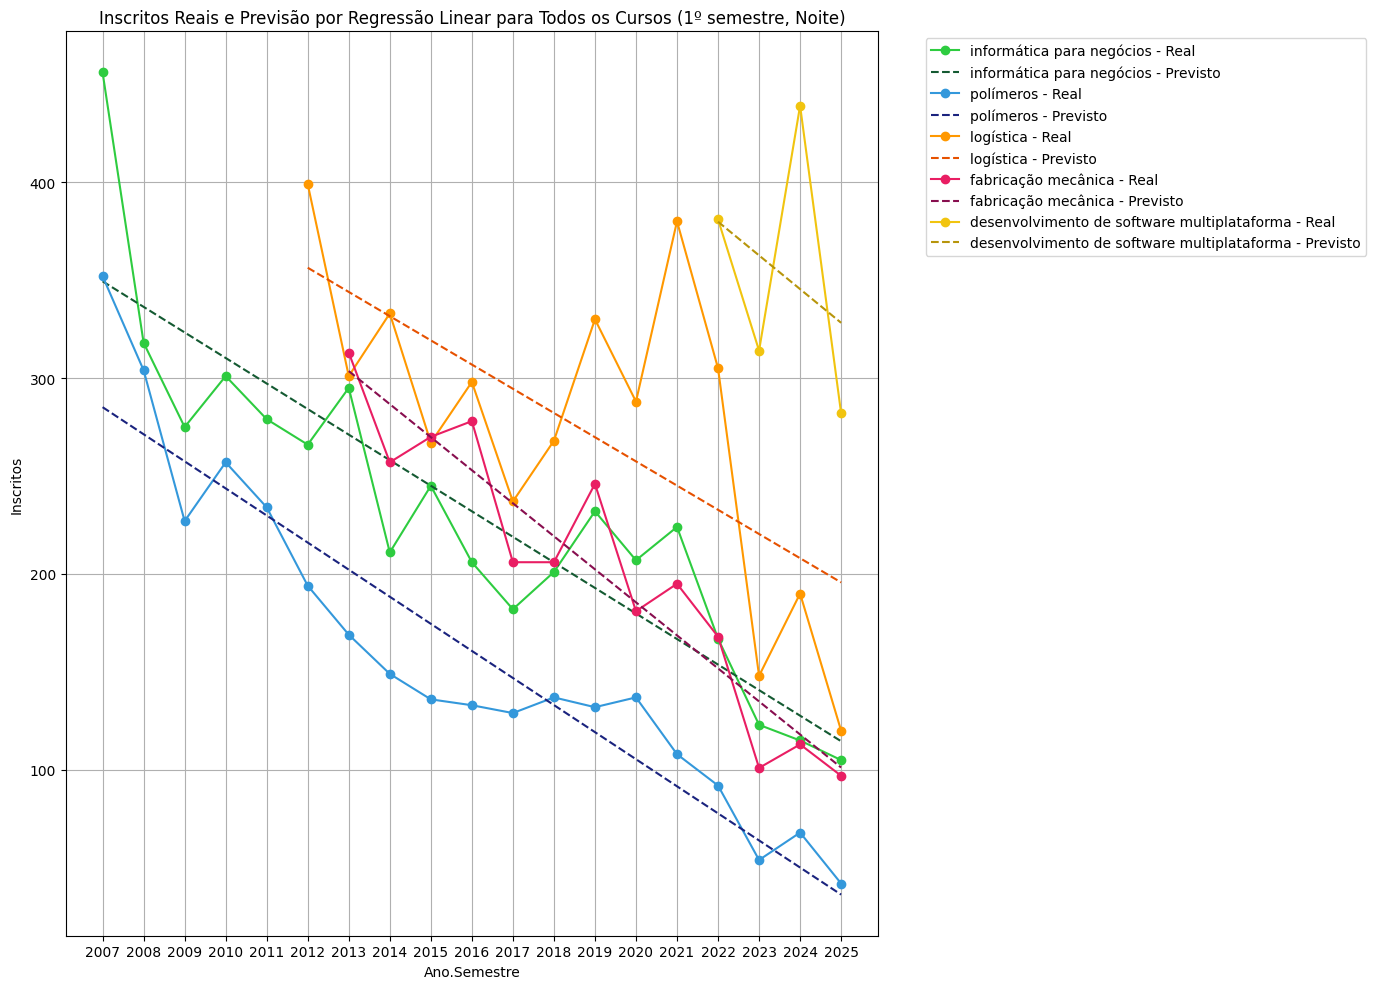

In [ ]:
# Filtra os dados para o 1º semestre no período noturno
df2 = demandas_fatec_maua(semestre=1, periodo="noite")

# Cria uma nova coluna 'AnoSemestre' combinando ano e semestre (ex: 2020.0, 2020.5)
# Isso facilita a visualização contínua no eixo x do gráfico
df2['anoSemestre'] = df2['ano'] + (df2['semestre'] - 1) * 0.5

# Define pares de cores para os gráficos (uma cor para os dados reais e outra para a linha de regressão)
color_pairs = [
    ('#2ecc40', '#145a32'),   # verde e verde escuro
    ('#3498db', '#1a237e'),   # azul e azul escuro
    ('#ff9800', '#e65100'),   # laranja e laranja escuro
    ('#e91e63', '#880e4f'),   # rosa e rosa escuro
    ('#f1c40f', '#b7950b'),   # amarelo e amarelo escuro
    ('#9b59b6', '#512e5f'),   # roxo e roxo escuro
]

# Cria a figura do gráfico com tamanho 14x10 polegadas
plt.figure(figsize=(14, 10))

# Obtém a lista de cursos únicos no DataFrame
cursos = df2['curso'].unique()

# Para cada curso, gera uma linha no gráfico
for idx, curso in enumerate(cursos):
    # Filtra os dados apenas para o curso atual
    dados = df2[df2['curso'] == curso]

    # Seleciona par de cores correspondente ao curso (reutiliza se faltar cores)
    color_real, color_pred = color_pairs[idx % len(color_pairs)]

    # Plota os dados reais de inscritos ao longo do tempo com marcadores
    plt.plot(dados['anoSemestre'], dados['inscritos'], marker='o', label=f'{curso} - Real', color=color_real)

    # Prepara dados para a linha de regressão linear (tendência)
    x = dados['anoSemestre']
    y = dados['inscritos']
    coef = np.polyfit(x, y, 1)         # Calcula coeficientes da reta (y = ax + b)
    y_pred = np.polyval(coef, x)       # Gera valores previstos com base na reta
    plt.plot(x, y_pred, linestyle='--', label=f'{curso} - Previsto', color=color_pred)  # Plota a linha de tendência


anos_semestre_unicos = sorted(df2['anoSemestre'].unique())
plt.xticks(anos_semestre_unicos)
# Configurações do gráfico
plt.xlabel('Ano.Semestre')  # Rótulo do eixo x
plt.ylabel('Inscritos')     # Rótulo do eixo y
plt.title('Inscritos Reais e Previsão por Regressão Linear para Todos os Cursos (1º semestre, Noite)')  # Título
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Posiciona a legenda fora do gráfico
plt.grid(True)        # Ativa grade de fundo
plt.tight_layout()    # Ajusta o layout para não cortar conteúdo
plt.show()            # Exibe o gráfico


- Para cada curso, foi ajustada uma regressão linear simples (ano x inscritos).
- O coeficiente angular indica a tendência de crescimento ou queda das inscrições ao longo dos anos.
- O coeficiente de determinação R² mostra o quanto a variação dos inscritos é explicada pelo tempo.
- O coeficiente de Pearson avalia a força da correlação entre ano e inscritos.

In [ ]:
df_resultados = pd.DataFrame(
    resultados,
    columns=["Curso", "R²", "Coef. Angular", "Coef. Linear"]
)
display(df_resultados)

,Curso,R²,Coef. Angular,Coef. Linear
0,polímeros,0.8827,-13.82,28027.52
1,logística,0.4136,-12.36,25216.67
2,informática para negócios,0.7890,-13.04,26524.88
3,fabricação mecânica,0.8846,-16.86,34248.05
4,desenvolvimento de software multiplataforma,0.1004,-17.20,35158.20


In [ ]:
df_pearsonr_resultados = pd.DataFrame(
    resultados_pearsonr,
    columns=["Curso","Pearson r", "Interpretação"]
)
display(df_pearsonr_resultados)

,Curso,Pearson r,Interpretação
0,polímeros,-0.9395,Forte
1,logística,-0.6431,Forte
2,informática para negócios,-0.8883,Forte
3,fabricação mecânica,-0.9405,Forte
4,desenvolvimento de software multiplataforma,-0.3168,Moderada


## Comparação com a Média Geral

- A média geral de inscritos por ano serve de referência para avaliar o desempenho relativo de cada curso.
- Cursos como DSM, Logística e, em anos anteriores, Informática para Negócios frequentemente superam a média geral.
- Polímeros e Fabricação Mecânica tendem a ficar abaixo da média nos últimos anos.

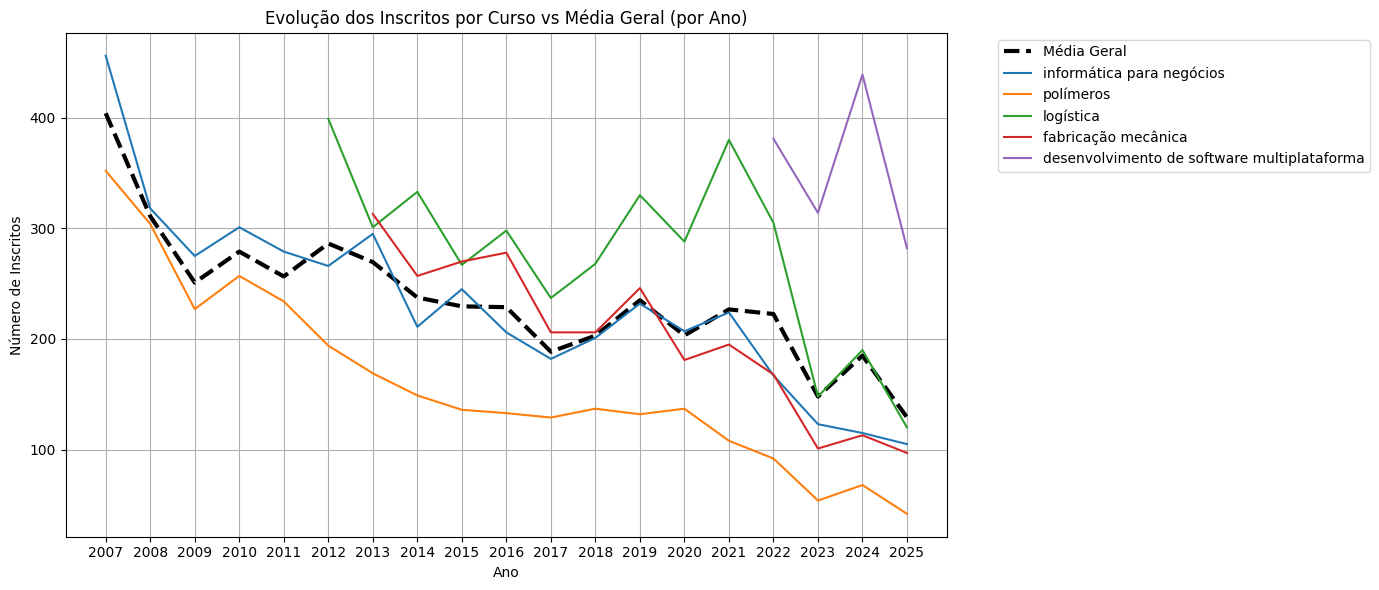

In [ ]:
import matplotlib.pyplot as plt

dfDsm = demandas_fatec_maua(semestre=1, periodo="noite")

media_geral_por_ano = dfDsm.groupby("ano")["inscritos"].mean().reset_index(name="Média Geral")

plt.figure(figsize=(14, 6))

# Plota a média geral de inscritos ao longo dos anos
plt.plot(media_geral_por_ano["ano"], media_geral_por_ano["Média Geral"], label="Média Geral", color="black", linewidth=3, linestyle='--')

# Para cada curso da lista, plota sua média de inscritos ao longo dos anos
for curso in cursos:
    dados_curso = dfDsm[dfDsm["curso"] == curso]
    inscritos_por_ano = dados_curso.groupby("ano")["inscritos"].mean().reset_index()
    plt.plot(inscritos_por_ano["ano"], inscritos_por_ano["inscritos"], label=curso)

# Garante que todos os anos presentes em qualquer linha sejam mostrados no eixo x
anos_todos = sorted(set(media_geral_por_ano['ano'].tolist() +
                        sum([dfDsm[dfDsm["curso"] == curso]['ano'].dropna().astype(int).tolist() for curso in cursos], [])))
plt.xticks(anos_todos)

plt.title("Evolução dos Inscritos por Curso vs Média Geral (por Ano)")
plt.xlabel("Ano")
plt.ylabel("Número de Inscritos")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Magnitude do Efeito (d de Cohen)

- O cálculo do d de Cohen mostra o quanto cada curso se distancia da média geral em termos padronizados.
- Valores próximos de zero indicam pouca diferença; valores maiores indicam que o curso está consistentemente acima ou abaixo da média.
- Por exemplo, se Logística apresenta d > 0.5, isso sugere que, historicamente, teve mais inscritos que a média geral.

In [ ]:
# Lista onde serão armazenados os resultados do cálculo do d de Cohen comparando cada curso com a média geral por ano
cohen_vs_media_geral = []

df2_1s_noturno_sem_dsm = demandas_fatec_maua(semestre=1, periodo="noite")

media_geral_por_ano = df2_1s_noturno_sem_dsm.groupby("ano")["inscritos"].mean()

# Função para calcular o d de Cohen, que mede a diferença padronizada entre dois grupos (curso vs média geral)
def cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))  # Desvio padrão combinado
    return (np.mean(x1) - np.mean(x2)) / pooled_std  # Diferença padronizada

# Loop para calcular o d de Cohen para cada curso
for curso in cursos:
    # Filtra os dados apenas do curso atual
    dados_curso = df2_1s_noturno_sem_dsm[df2_1s_noturno_sem_dsm["curso"] == curso]

    # Se não houver dados do curso, pula para o próximo
    if dados_curso.empty:
        continue

    # Inicializa listas para armazenar os valores de inscritos do curso e da média geral, ano a ano
    curso_vals = []
    media_vals = []

    # Para cada ano em que o curso aparece, coleta os inscritos e a média geral correspondente
    for ano in dados_curso["ano"].unique():
        inscritos_curso_ano = dados_curso[dados_curso["ano"] == ano]["inscritos"].values
        media_geral_ano = media_geral_por_ano.get(ano)

        # Garante que os dados são válidos antes de incluir nos cálculos
        if len(inscritos_curso_ano) > 0 and not np.isnan(media_geral_ano):
            curso_vals.extend(inscritos_curso_ano)
            media_vals.extend([media_geral_ano] * len(inscritos_curso_ano))

    # Calcula o d de Cohen se houver dados suficientes
    if len(curso_vals) > 1 and len(media_vals) > 1:
        d = cohen_d(np.array(curso_vals), np.array(media_vals))
        cohen_vs_media_geral.append((curso, d))

# Interpretação qualitativa dos valores de d de Cohen
interpretations_media = []
for curso, d in cohen_vs_media_geral:
    if abs(d) < 0.2:
        interpret = "Efeito desprezível"
    elif abs(d) < 0.5:
        interpret = "Efeito pequeno/moderado"
    elif abs(d) < 0.8:
        interpret = "Efeito médio"
    elif abs(d) < 1.2:
        interpret = "Efeito grande"
    elif abs(d) < 2.0:
        interpret = "Efeito muito grande"
    else:
        interpret = "Efeito enorme"
    interpretations_media.append((curso, round(d, 3), interpret))

# Cria um DataFrame organizado com os resultados finais
df_cohen_media = pd.DataFrame(
    interpretations_media,
    columns=["Curso", "Cohen's d (vs média geral)", "Interpretação"]
)

# Exibe a tabela final
df_cohen_media

,Curso,Cohen's d (vs média geral),Interpretação
0,informática para negócios,-0.063,Efeito desprezível
1,polímeros,-1.044,Efeito grande
2,logística,0.969,Efeito grande
3,fabricação mecânica,-0.103,Efeito desprezível
4,desenvolvimento de software multiplataforma,3.176,Efeito enorme


## Considerações sobre a Demanda

- Os dados refletem a tendência municipal: cursos de tecnologia e gestão como DSM e Logística têm alta procura, enquanto áreas industriais tradicionais mostram queda ou estabilidade.
- O contexto do vestibular da Fatec de Mauá mostra que DSM, Logística e Informática para Negócios acompanham a tendência de alta concorrência em todo o município de Mauá.

### Limitações e Observações

- As tendências negativas em cursos como Polímeros e Fabricação Mecânica podem indicar necessidade de revisão curricular, divulgação ou adequação à demanda do mercado.
- O aumento recente em DSM reflete tanto a expansão do curso quanto a maior procura por tecnologia, alinhada com o cenário nacional.
- Pequenas flutuações podem ser atribuídas a fatores externos (pandemia, mudanças no vestibular, mercado de trabalho, etc), como pode ser observado no pico de 2020 e 2021.

### Resumo Final

- Informática para Negócios e Logística foram historicamente os cursos mais procurados, mas vêm perdendo inscritos nos últimos anos.
- Polímeros apresenta queda acentuada e pode demandar ações institucionais.
- Fabricação Mecânica segue tendência de baixa, comum em áreas industriais, como é o caso de Mauá que está na região do ABC.
- Desenvolvimento de Software Multiplataforma mostra crescimento recente e alta demanda, alinhado com a tendência estadual e nacional.
- A média geral de inscritos caiu ao longo dos anos, refletindo desafios de captação e mudanças no perfil dos candidatos.